# Imports

In [28]:
import os
from sys import maxsize
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential, load_model
from keras.layers import Convolution2D, Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.applications import ResNet50, InceptionV3, Xception

# Directories

In [29]:
cwd = os.getcwd()
train_dir = os.path.join(cwd,'Shopping Assistant','data', 'train')
test_dir = os.path.join(cwd,'Shopping Assistant','data', 'test')
model_dir = os.path.join(cwd,'Shopping Assistant','models','baselineCNN.h5')

# Utilities

In [30]:
def getLabel(result):
    if (result[0][0]==1):
        outcome='burger'
    elif(result[0][1]==1):
        outcome='hotdog'
    elif (result[0][2]==1):
        outcome='ice_cream'
    elif ( result[0][3]==1):
        outcome='pizza'
    else:
        outcome='Unable to Determine'
    return outcome
    

In [31]:
def getFinalLabel(results):
    labels = ['burger', 'hotdog', 'ice_cream', 'pizza', 'Unable to Determine']
    predSet = set()
    count = [0, 0, 0, 0, 0]
    for i in range(4):
        if(results[i] in labels):
            predSet.add(results[i])
            idx = labels.index(results[i])
            count[idx] = count[idx] + 1
            if(count[idx]>=2):
                return results[i]
            
    return predSet[-1]
        

In [32]:
def getGroceries(label):
    burgerGroceries = ['bread', 'tomato', 'potato', 'cheese']
    burgerGroceriesId = [0, 5, 6, 1]
    hotdogGroceries = ['bread', 'tomato', 'sausage', 'ketchup']
    hotdogGroceriesId = [0, 5, 2, 3]
    ice_creamGroceries = ['ice', 'cream', 'milk', 'chocolate']
    ice_creamGroceriesId = [4, 7, 9, 8]
    pizzaGroceries = ['bread', 'tomato', 'cheese', 'sausage']
    pizzaGroceriesId = [0, 5, 1, 2]
    if(label=='burger'):
        return [burgerGroceries, burgerGroceriesId]
    elif(label=='hotdog'):
        return [hotdogGroceries, hotdogGroceriesId]
    elif(label=='ice_cream'):
        return [ice_creamGroceries, ice_creamGroceriesId]
    elif(label=='pizza'):
        return [pizzaGroceries, pizzaGroceriesId]
    else:
        return [['Nothing'], [0, 0, 0, 0]]

# Training Data Generation

In [33]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size=(180, 180),
                                                 batch_size=5,
                                                 class_mode='categorical'
                                                 #shuffle=True
                                                )

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size=(180, 180),
                                            batch_size=5,
                                            class_mode='categorical'
                                            #shuffle=True
                                           ) 

Found 851 images belonging to 4 classes.
Found 58 images belonging to 4 classes.


# Baseline Model

In [34]:
classifier = Sequential()

classifier.add(Conv2D(32,(3,3), activation='relu', input_shape=(180, 180, 3), padding="same"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#classifier.add(Dropout(0.2))

classifier.add(Conv2D(64,(3,3), activation='relu', padding="same"))
classifier.add(BatchNormalization())

classifier.add(Conv2D(64,(3,3), activation='relu', padding="same"))
classifier.add(BatchNormalization())

classifier.add(Conv2D(64,(3,3), activation='relu', padding="same"))
classifier.add(BatchNormalization())

classifier.add(Conv2D(64,(3,3), activation='relu', padding="same"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#classifier.add(Dropout(0.2))

classifier.add(Conv2D(128,(3,3), activation='relu', padding="same"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2, 2)))
#classifier.add(Dropout(0.2))


classifier.add(Flatten())

classifier.add(Dense(256, activation='relu'))
classifier.add(BatchNormalization())
#classifier.add(Dropout(0.15))

classifier.add(Dense(128, activation='relu'))
classifier.add(BatchNormalization())
#classifier.add(Dropout(0.15))

classifier.add(Dense(64, activation='relu'))
classifier.add(BatchNormalization())
#classifier.add(Dropout(0.15))

classifier.add(Dense(4, activation = 'softmax'))

opt = Adam(learning_rate=0.01)
classifier.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

print(classifier.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_383 (Conv2D)          (None, 180, 180, 32)      896       
_________________________________________________________________
batch_normalization_386 (Bat (None, 180, 180, 32)      128       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_384 (Conv2D)          (None, 90, 90, 64)        18496     
_________________________________________________________________
batch_normalization_387 (Bat (None, 90, 90, 64)        256       
_________________________________________________________________
conv2d_385 (Conv2D)          (None, 90, 90, 64)        36928     
_________________________________________________________________
batch_normalization_388 (Bat (None, 90, 90, 64)       

# Training Model

In [35]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(model_dir, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history=classifier.fit_generator(
        training_set,
        steps_per_epoch=851/5, 
        epochs=40,
        validation_data=test_set,
        validation_steps=58/5,
        callbacks=[es, mc]
)

Epoch 1/40
171/170 [==============================] - 214s 1s/step - loss: 1.4927 - accuracy: 0.3537 - val_loss: 1.2922 - val_accuracy: 0.4483

Epoch 00001: val_accuracy improved from -inf to 0.44828, saving model to D:\Projects\Shopping Assistant\models\baselineCNN.h5
Epoch 2/40
171/170 [==============================] - 191s 1s/step - loss: 1.2550 - accuracy: 0.4465 - val_loss: 2.9653 - val_accuracy: 0.2241

Epoch 00002: val_accuracy did not improve from 0.44828
Epoch 3/40
171/170 [==============================] - 193s 1s/step - loss: 1.3199 - accuracy: 0.4254 - val_loss: 1.2971 - val_accuracy: 0.5000

Epoch 00003: val_accuracy improved from 0.44828 to 0.50000, saving model to D:\Projects\Shopping Assistant\models\baselineCNN.h5
Epoch 4/40
171/170 [==============================] - 195s 1s/step - loss: 1.2641 - accuracy: 0.4524 - val_loss: 1.4710 - val_accuracy: 0.2931

Epoch 00004: val_accuracy did not improve from 0.50000
Epoch 5/40
171/170 [==============================] - 193s 

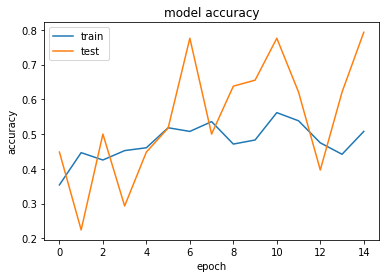

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Test Image

In [40]:
test_img_dir = os.path.join(test_dir, 'pizza', '5.jpg')

# BaseLine Prediction

In [42]:
classifier = load_model(model_dir)
test_img = image.load_img(test_img_dir, target_size = (180, 180))
test_img = image.img_to_array(test_img)
test_img = np.expand_dims(test_img, axis=0)

result = classifier.predict(test_img)
BaseLinePred = getLabel(result)
print('Predicted:', BaseLinePred)

Predicted: ice_cream


# Resnet50 Prediction

In [43]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

resnet50 = ResNet50(weights='imagenet')
img = image.load_img(test_img_dir, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

ResNetPred = resnet50.predict(x)
ResNetPred = decode_predictions(ResNetPred, top=1)[0][0][1]
print('Predicted:', ResNetPred)

Predicted: pizza


# InceptionV3 Prediction

In [44]:
from keras.applications.inception_v3 import preprocess_input, decode_predictions

inceptionV3 = InceptionV3(weights='imagenet')
img = image.load_img(test_img_dir, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

InceptionPred = inceptionV3.predict(x)
InceptionPred = decode_predictions(InceptionPred, top=1)[0][0][1]
print('Predicted:', InceptionPred)

Predicted: pizza


# Xception Prediction

In [45]:
from keras.applications.xception import preprocess_input, decode_predictions

xception = InceptionV3(weights='imagenet')
img = image.load_img(test_img_dir, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

XceptionPred = xception.predict(x)
XceptionPred = decode_predictions(XceptionPred, top=1)[0][0][1]
print('Predicted:', XceptionPred)

Predicted: pizza


# Getting best prediction, groceries and their ids

In [46]:
results = [BaseLinePred, ResNetPred, InceptionPred, XceptionPred]
finalPrediction = getFinalLabel(results)
groceries = getGroceries(finalPrediction)
groceriesLabels = groceries[0]
groceriesIds = groceries[1]
print('Food Item Detected: ', finalPrediction)
print('Groceries required: ')
for i in range(4):
    print(i+1,' ',groceriesLabels[i])
print('Groceries ids: ', groceriesIds)

Food Item Detected:  pizza
Groceries required: 
1   bread
2   tomato
3   cheese
4   sausage
Groceries ids:  [0, 5, 1, 2]


# Pathfinding

In [47]:
INT_MAX = maxsize
def initialise(V):
    global dis, Next

    for i in range(V):
        for j in range(V):
            dis[i][j] = graph[i][j]

            # No edge between node
            # i and j
            if (graph[i][j] == INF):
                Next[i][j] = -1
            else:
                Next[i][j] = j

In [48]:
def constructPath(u, v):
    global graph, Next

    # If there's no path between
    # node u and v, simply return
    # an empty array
    if (Next[u][v] == -1):
        return {}

    # Storing the path in a vector
    path = [u]
    while (u != v):
        u = Next[u][v]
        path.append(u)

    return path

In [49]:
# Standard Floyd Warshall Algorithm
# with little modification Now if we find
# that dis[i][j] > dis[i][k] + dis[k][j]
# then we modify next[i][j] = next[i][k]
def floydWarshall(V):
    global dist, Next
    for k in range(V):
        for i in range(V):
            for j in range(V):   
                # We cannot travel through
                # edge that doesn't exist
                if (dis[i][k] == INF or dis[k][j] == INF):
                    continue
                if (dis[i][j] > dis[i][k] + dis[k][j]):
                    dis[i][j] = dis[i][k] + dis[k][j]
                    Next[i][j] = Next[i][k]

In [54]:
# Prthe shortest path
def printPath(path):
    n = len(path)
    for i in range(n - 1):
        print(path[i], end=" -> ")
    if n>=1:
        print (path[n - 1])

In [55]:
# Returns true if edge u-v is a valid edge to be
# include in MST. An edge is valid if one end is
# already included in MST and other is not in MST.
def isValidEdge(u, v, inMST):
    if u == v:
        return False
    if inMST[u] == False and inMST[v] == False:
        return False
    elif inMST[u] == True and inMST[v] == True:
        return False
    return True

In [56]:
def primMST(cost):
    inMST = [False] * V1

    # Include first vertex in MST
    inMST[0] = True

    # Keep adding edges while number of included
    # edges does not become V-1.
    edge_count = 0
    mincost = 0
    while edge_count < V1 - 1:

        # Find minimum weight valid edge.
        minn = INT_MAX
        a = -1
        b = -1
        for i in range(V1):
            for j in range(V1):
                if cost[i][j] < minn:
                    if isValidEdge(i, j, inMST):
                        minn = cost[i][j]
                        a = i
                        b = j

        if a != -1 and b != -1:
            print("Edge %d: (%d, %d) cost: %d" %
                (edge_count, a, b, minn))
            printPath(constructPath(a,b))
            edge_count += 1
            mincost += minn
            inMST[b] = inMST[a] = True
            print("Minimum cost = %d" % mincost)

In [57]:
''' Let us create the following graph
    2 3
(0)--(1)--(2)
| / \ |
6| 8/ \5 |7
| /	 \ |
(3)-------(4)
        9   '''

# Print the solution

V=4
MAXM,INF = 100,INT_MAX
dis = [[-1 for i in range(MAXM)] for i in range(MAXM)]
Next = [[-1 for i in range(MAXM)] for i in range(MAXM)]


graph = [ 
    [ 0, 2, INF, INF, INF, 9, INF, INF, INF, INF],
    [ 2, 0, INF, INF, 6, INF, 4, INF, INF, INF],
    [ INF, INF, 0, INF, 4, INF, 3, INF, 5, INF],
    [ INF, INF, INF, 0, 2, 1, INF, INF, INF, 3],
    [ INF, 6, 4, 2, 0, INF, INF, INF, INF, INF],
    [ 9, INF, INF, 1, INF, 0, INF, 6, INF, INF],
    [ INF, 4, 3, INF, INF, INF, 0, INF, INF, INF],
    [ INF, INF, INF, INF, INF, 6, INF, 0, INF, 3],
    [ INF, INF, 5, INF, INF, INF, INF, INF, 0, 7],
    [ INF, INF, INF, 3, INF, INF, INF, 3, 7, 0]
]

# Function to initialise the
# distance and Next array
initialise(V)
#Calling Floyd Warshall Algorithm,
# this will update the shortest
# distance as well as Next array
floydWarshall(V)
required = groceriesIds
result= [[-1 for i in range(len(required))] for i in range(len(required))]
global V1
V1=len(required)
for i in range(len(required)):
    for j in range(i,len(required)):
        result[i][j]=dis[required[i]][required[j]]
        result[j][i]=dis[required[j]][required[i]]
print(result)
primMST(result)

[[0, -1, 2, 9223372036854775807], [-1, -1, -1, -1], [2, -1, 0, 9223372036854775807], [9223372036854775807, -1, 9223372036854775807, 0]]
Edge 0: (0, 1) cost: -1
0 -> 1
Minimum cost = -1
Edge 1: (1, 2) cost: -1
Minimum cost = -2
Edge 2: (1, 3) cost: -1
Minimum cost = -3
